# Receiver Operating Characteristic

In [101]:
suppressPackageStartupMessages(library(tidyverse))

## Logistic regression concept

In logistic regression, we want to relate some predictor variable (e..g gene expression value) to the **probability** of a binary outcome. We would like a linear model since that is mathematically and computationally tractable, but run into the issue that probabilities are restricted to [0,1]. Logistic regression solves this by transforming the output of a linear model into the [0, 1] range.

In [102]:
n <- 50
x <- seq(-4, 4, length.out = n)
a = 0
b = 1

lx <- a + b*x
px <- exp(lx)/(1 + exp(lx))
y <- rbinom(n, 1, px)

df <- data.frame(y=y, x=x, lx=lx, px=px)

In [103]:
options(repr.plot.width=4, repr.plot.height=3)

### A linear model cannot be directly interpreted as a probability

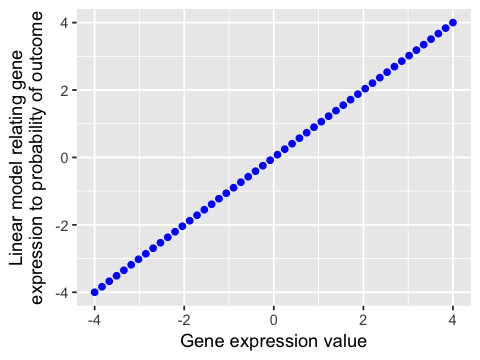

In [104]:
ggplot(df, aes(x=x, y=lx)) + 
geom_point(color='blue') +
labs(x="Gene expression value", 
     y="Linear model relating gene\nexpression to probability of outcome")

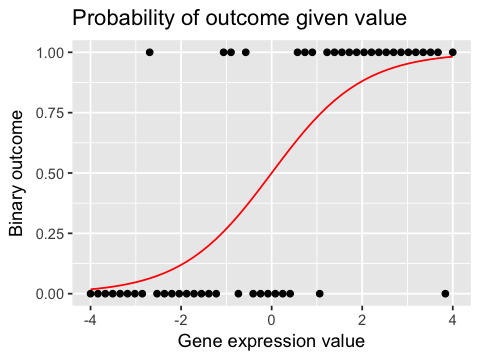

In [105]:
ggplot(df, aes(x=x, y=y)) + 
geom_point() +
geom_line(aes(y=px), color='red') +
labs(x="Gene expression value", y="Binary outcome", 
     title="Probability of outcome given value")

## Simulation from logistic model

In [106]:
sim.binomial <- function(n, b0, b1, b2, b3) { 
    x1 <- rnorm(n)
    x2 <- rnorm(n)
    x3 <- rnorm(n)
    lx <- b0 + b1 * x1 + b2 * x2 + b3 * x3 
    px <- exp(lx)/(1 + exp(lx))
    y <- rbinom(n, 1, px)
    data.frame(y, px, x1, x2, x3)
}

## LOOCV

In [107]:
set.seed(31219)
data <- sim.binomial(100, 0.1, 0, 1, 0)

In [108]:
head(data)

y px        x1        x2          x3        
1 0 0.5830298 1.2472628  0.23522348  1.4787281
2 1 0.4546145 0.5804904 -0.28204321 -0.8217013
3 1 0.5417889 0.3065363  0.06754626  1.3946841
4 1 0.8080377 0.4604304  1.33730956  0.6502840
5 0 0.5436883 1.2094387  0.07519995  0.6585957
6 1 0.4011430 0.2338796 -0.50070506 -0.8225897

In [119]:
n <- nrow(data)
pred <- numeric(n)
for (i in 1:n) {
    train <- data[-i,]
    test <- data[i,]
    model <- glm(y ~ x1 + x2 + x3, data=train, family="binomial")
    pred[i] <- predict(model, test, type="response")
}
yhat <- ifelse(pred < 0.5, 0, 1)
preddat <- data.frame(probhat=pred, yhat=yhat, y=data$y)

## Confusion matrix

In [120]:
suppressPackageStartupMessages(library(caret))

In [123]:
tbl <- table(yhat, data$y)
confusionMatrix(tbl)

Confusion Matrix and Statistics

    
yhat  0  1
   0 31 26
   1 21 22
                                          
               Accuracy : 0.53            
                 95% CI : (0.4276, 0.6306)
    No Information Rate : 0.52            
    P-Value [Acc > NIR] : 0.4607          
                                          
                  Kappa : 0.0547          
 Mcnemar's Test P-Value : 0.5596          
                                          
            Sensitivity : 0.5962          
            Specificity : 0.4583          
         Pos Pred Value : 0.5439          
         Neg Pred Value : 0.5116          
             Prevalence : 0.5200          
         Detection Rate : 0.3100          
   Detection Prevalence : 0.5700          
      Balanced Accuracy : 0.5272          
                                          
       'Positive' Class : 0               
                                          

## ROC and AUC

In [124]:
suppressPackageStartupMessages(library(ROCR))

### Helper functions

In [125]:
ROC <- function(preddat, mlab = "probhat", ylab = "y") {
    m <- preddat[[mlab]]
    y <- preddat[[ylab]]
    performance(prediction(m, y), measure = "tpr", x.measure = "fpr")
}

AUC <- function(preddat, mlab = "probhat", ylab = "y") { 
    m <- preddat[[mlab]]
    y <- preddat[[ylab]]
    performance(prediction(m, y), "auc")@y.values[[1]]
}

## Calculate and plot ROC and AUC

In [126]:
my.roc <- ROC(preddat)
my.auc <- AUC(preddat)

In [127]:
my.auc

[1] 0.5300481

In [128]:
options(repr.plot.width=4, repr.plot.height=4)

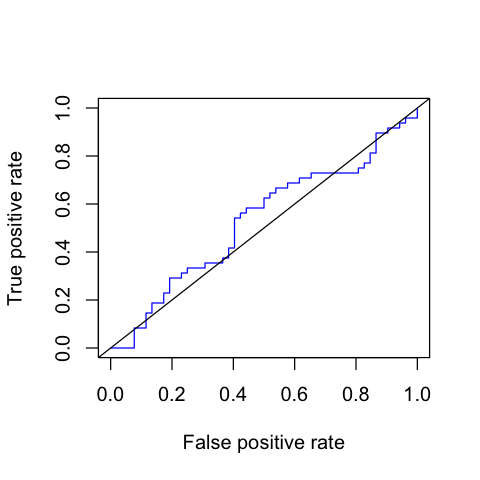

In [129]:
plot(my.roc, col = "blue")
abline(0, 1)

## Resubstitution ROC

In [134]:
model.1 <- glm(y ~ x1 + x2 + x3, data=data, family="binomial")
pred.1 <- predict(model.1, type="response")
yhat.1 <- ifelse(pred.1 < 0.5, 0, 1)
preddat.1 <- data.frame(probhat=pred.1, yhat=yhat.1, y=data$y)

In [136]:
rs.roc <- ROC(preddat.1)
rs.auc <- AUC(preddat.1)

In [137]:
rs.auc

[1] 0.6169872

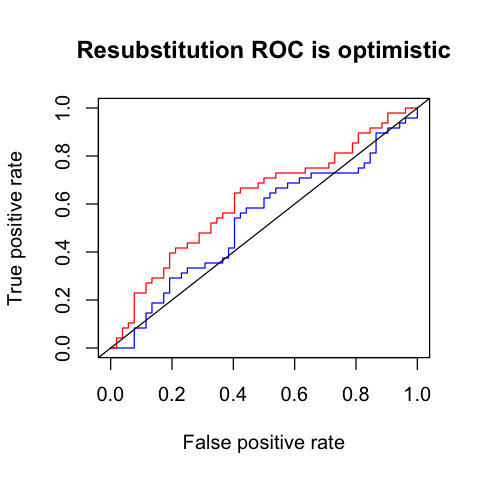

In [144]:
plot(my.roc, col = "blue", main="Resubstitution ROC is optimistic")
plot(rs.roc, col = "red", add=TRUE)
abline(0, 1)